# GIK Character Prediction Model

Train a model to predict keyboard characters from IMU sensor data.


In [68]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# Add project root to path
PROJECT_ROOT = os.path.dirname(os.path.abspath('__file__'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from pretraining import preprocess_and_export, preprocess_multiple_sources, load_preprocessed_dataset, export_dataset_to_csv
from src.pre_processing.alignment import INDEX_TO_CHAR, CHAR_TO_INDEX, NUM_CLASSES
from ml.models.gik_model import create_model_auto_input_dim, GIKTrainer, decode_predictions
from ml.models.loss_functions.custom_losses import FocalLoss, CoordinateLoss

torch.manual_seed(42)
np.random.seed(42)

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"PyTorch {torch.__version__} | Device: {DEVICE}")

PyTorch 2.10.0+cpu | Device: cpu


## Configuration

In [69]:
# Data paths - Using data_hazel_2 with multiple sources
DATA_DIR = "data_right"

# Multiple data sources (paired keyboard + IMU files)
KEYBOARD_FILES = ["Keyboard_4.csv", "Keyboard_5.csv", "Keyboard_6.csv", "Keyboard_7.csv", "Keyboard_8.csv", "Keyboard_9.csv"]
LEFT_FILES = None
RIGHT_FILES = ["Right_4.csv", "Right_5.csv", "Right_6.csv", "Right_7.csv", "Right_8.csv", "Right_9.csv"]

PROCESSED_DATA_PATH = os.path.join(DATA_DIR, "processed_dataset.pt")

# Training config - OPTIMIZED (best: LSTM + Focal Loss ~37% test acc)
CONFIG = {
    # PRE-PROCESSING ARGS
    'max_seq_length': 10,
    
    # GIK Model WRAPPER ARGS (Input Projection Layer + Classification Head) 
    'hidden_dim_classification_head': 64,
    'num_layers': 1,
    'dropout': 0.5,  # Increased for regularization
    
    # TRAINER ARGS 
    'batch_size': 64,
    'learning_rate': 5e-4,
    'weight_decay': 1e-3,  # L2 regularization
    'epochs': 200,
    'early_stopping': 30,
    
    # INNER MODEL ARGS
    # Model: 'lstm' (best) | 'transformer' | 'attention_lstm' | 'gru' | 'rnn' | 'cnn'
    'model_type': 'lstm',
    'hidden_dim_inner_model': 128,
    'inner_model_prams': {'bidirectional' : True, 'dropout' : 0.5, 'num_layers' : 2},
    
    # LOSS Function ARGS
    'loss': FocalLoss,  # Handles class imbalance
    'loss_params': {"gamma" : 2.0},
}

print(f"Data dir: {DATA_DIR}")
print(f"Keyboard files: {KEYBOARD_FILES}")
print(f"Left IMU files: {LEFT_FILES}")
print(f"Right IMU files: {RIGHT_FILES}")
print(f"Model: {CONFIG['model_type']}")
print(f"Seq length: {CONFIG['max_seq_length']}")

Data dir: data_right
Keyboard files: ['Keyboard_4.csv', 'Keyboard_5.csv', 'Keyboard_6.csv', 'Keyboard_7.csv', 'Keyboard_8.csv', 'Keyboard_9.csv']
Left IMU files: None
Right IMU files: ['Right_4.csv', 'Right_5.csv', 'Right_6.csv', 'Right_7.csv', 'Right_8.csv', 'Right_9.csv']
Model: lstm
Seq length: 10


## Preprocess Data

In [3]:
# Preprocess and combine multiple data sources
metadata = preprocess_multiple_sources(
    data_dir=DATA_DIR,
    keyboard_files=KEYBOARD_FILES,
    left_files=LEFT_FILES,
    right_files=RIGHT_FILES,
    output_path=PROCESSED_DATA_PATH,
    max_seq_length=CONFIG['max_seq_length'],
    normalize=True,
    apply_filtering=True
)
print(f"\nTotal Samples: {metadata['num_samples']} | Input dim: {metadata['input_dim']} | Sources: {metadata['num_sources']}")

Loading data from data_right...
  Keyboard files: ['Keyboard_4.csv', 'Keyboard_5.csv', 'Keyboard_6.csv', 'Keyboard_7.csv', 'Keyboard_8.csv', 'Keyboard_9.csv']
  Right IMU files: ['Right_4.csv', 'Right_5.csv', 'Right_6.csv', 'Right_7.csv', 'Right_8.csv', 'Right_9.csv']

Processing source 1/6: Keyboard_4.csv
Skipped characters not in vocabulary: {'[': 3, ';': 2, 'esc': 1}
  Added 122 samples (total: 122)

Processing source 2/6: Keyboard_5.csv
Skipped characters not in vocabulary: {';': 1, '=': 1, 'esc': 1}
  Added 172 samples (total: 294)

Processing source 3/6: Keyboard_6.csv
Skipped characters not in vocabulary: {'ctrl': 1, 'esc': 1}
  Added 164 samples (total: 458)

Processing source 4/6: Keyboard_7.csv
Skipped characters not in vocabulary: {'esc': 1}
  Added 101 samples (total: 559)

Processing source 5/6: Keyboard_8.csv
Skipped characters not in vocabulary: {';': 2, 'ctrl': 1, 'esc': 1}
  Added 282 samples (total: 841)

Processing source 6/6: Keyboard_9.csv
Skipped characters not in

In [4]:
# Export to CSV for inspection (optional)
export_dataset_to_csv(PROCESSED_DATA_PATH, DATA_DIR, include_features=True)

Saved summary to data_right\dataset_summary.csv
Saved features to data_right\dataset_features.csv

Dataset Info:
  Total samples: 1080
  Exported samples: 1080
  Input dim: 99
  Max seq length: 10
  Num classes: 40

Class Distribution:
  o: 188
  j: 123
  h: 122
  SPACE: 106
  k: 92
  i: 89
  l: 81
  p: 63
  u: 62
  n: 51
  BACKSPACE: 28
  g: 24
  y: 21
  b: 18
  m: 10


'data_right\\dataset_summary.csv'

## Load Dataset & Create Model

In [ ]:
dataset = load_preprocessed_dataset(PROCESSED_DATA_PATH)
print(f"Dataset: {len(dataset)} samples | Input dim: {dataset.input_dim}")

# Create model
model = create_model_auto_input_dim(
    dataset,
    model_type=CONFIG['model_type'],
    hidden_dim_inner_model=CONFIG['hidden_dim_inner_model'],
    hidden_dim_classification_head=CONFIG['hidden_dim_classification_head'],
    no_layers_classification_head=CONFIG['num_layers'],
    dropout_inner_layers=CONFIG['dropout'],
    inner_model_kwargs=CONFIG['inner_model_prams']
)

# Print model architecture
print("\n" + "=" * 60)
print("Model architecture")
print("=" * 60)
print(model)
print("=" * 60)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Dataset: 1080 samples | Input dim: 99

Model architecture
GIKModelWrapper(
  (input_projection): Sequential(
    (0): Linear(in_features=99, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (inner_model): LSTMModel(
    (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (projection): Linear(in_features=256, out_features=128, bias=True)
  )
  (project_from_inner): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (fc_stack): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=40, bias=True)
  )
)
Parameters: 717,256
Parameters: 717,256


## Train Model

In [6]:
trainer = GIKTrainer(
    model=model,
    dataset=dataset,
    batch_size=CONFIG['batch_size'],
    learning_rate=CONFIG['learning_rate'],
    device=DEVICE,
    loss=CONFIG.get('loss'),
    loss_kwargs=CONFIG.get('loss_params')
)

history = trainer.train(
    epochs=CONFIG['epochs'],
    early_stopping_patience=CONFIG['early_stopping']
)

Training on cpu
Train: 864, Val: 108, Test: 108 (causal split, no shuffle)
------------------------------------------------------------
Epoch   1/200 | Train Loss: 3.4002 | Train Acc: 0.1157 | Val Loss: 3.4495 | Val Acc: 0.0278
  -> Saved best model (val_loss: 3.4495)
Epoch   2/200 | Train Loss: 3.0254 | Train Acc: 0.2014 | Val Loss: 3.2603 | Val Acc: 0.0648
  -> Saved best model (val_loss: 3.2603)
Epoch   3/200 | Train Loss: 2.7919 | Train Acc: 0.2743 | Val Loss: 3.1311 | Val Acc: 0.0833
  -> Saved best model (val_loss: 3.1311)
Epoch   4/200 | Train Loss: 2.5896 | Train Acc: 0.3206 | Val Loss: 2.9230 | Val Acc: 0.1296
  -> Saved best model (val_loss: 2.9230)
Epoch   5/200 | Train Loss: 2.3854 | Train Acc: 0.3704 | Val Loss: 2.8540 | Val Acc: 0.1204
  -> Saved best model (val_loss: 2.8540)
Epoch   6/200 | Train Loss: 2.2150 | Train Acc: 0.4051 | Val Loss: 2.7294 | Val Acc: 0.1296
  -> Saved best model (val_loss: 2.7294)
Epoch   7/200 | Train Loss: 2.1075 | Train Acc: 0.4340 | Val Loss:

## Model Evaluation and Parameters Visualisation

In [58]:
# Put any data gathering functions here so we only need to run the plotting cell once

# 1. Plot distribution of all the weights

all_weights = []
zero_weights = 0

for param in model.parameters(): # Get all weights (we cannot get all at the same time)

    all_weights.extend(param.cpu().detach().numpy().flatten()) # translate pytorch tensor to numpy
    zero_weights += np.sum(np.abs(param.cpu().detach().numpy()) <= 1e-4) # count small weights

# 2. Show the mean and standard deviation

weight_mean = np.mean(all_weights)
weight_std = np.std(all_weights)
max = np.max(all_weights)
min = np.min(all_weights)

# Helper function to display predictions
def show_predictions(data_subset, subset_name, max_samples=50):
    """Show predictions for a dataset subset."""
    model.eval()
    correct = 0
    results = []
    
    with torch.no_grad():
        for idx in range(len(data_subset)):
            x, y_true = data_subset[idx]
            x = x.unsqueeze(0).to(DEVICE)
            y_pred = model(x)
            
            true_char = INDEX_TO_CHAR.get(y_true.argmax().item(), '?')
            pred_char = INDEX_TO_CHAR.get(y_pred.argmax().item(), '?')
            
            is_correct = true_char == pred_char
            if is_correct:
                correct += 1
            
            results.append((true_char, pred_char, is_correct))
    
    # Print header
    print(f"=== {subset_name} Predictions ({correct}/{len(results)} correct = {correct/len(results):.2%}) ===")
    print()
    
    # Show samples (up to max_samples)
    # n_show = min(max_samples, len(results))
    # for i, (true_char, pred_char, is_correct) in enumerate(results[:n_show]):
    #     # Display special chars nicely
    #     true_disp = {'\n': 'ENTER', ' ': 'SPACE', '\t': 'TAB', '\b': 'BKSP'}.get(true_char, true_char)
    #     pred_disp = {'\n': 'ENTER', ' ': 'SPACE', '\t': 'TAB', '\b': 'BKSP'}.get(pred_char, pred_char)
    #     match = '✓' if is_correct else '✗'
    #     print(f"{match} True: {true_disp:8} | Pred: {pred_disp:8}")
    
    # if len(results) > n_show:
    #     print(f"... and {len(results) - n_show} more samples")
    # print()



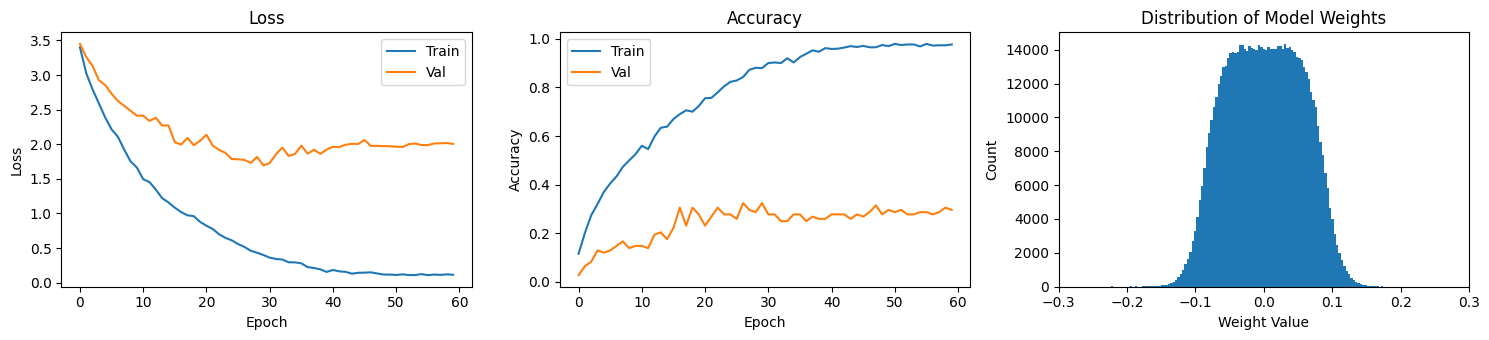

Weight mean: 0.0013 | Weight std: 0.0584 | Max weight: 1.3007 | Min weight: -0.4313 | Zero weights: 861

Validation Loss: 2.0056 | Validation Accuracy: 29.63%
=== Validation Predictions (32/108 correct = 29.63%) ===

Test Loss: 1.5274 | Test Accuracy: 51.85%
=== Test Predictions (56/108 correct = 51.85%) ===



In [59]:
# Show everything together
fig, axes = plt.subplots(1, 3, figsize=(15, 3.5))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Accuracy')

axes[2].hist(all_weights, bins=500)
axes[2].set_xlabel("Weight Value")
axes[2].set_ylabel("Frequency")
axes[2].set_xlim(-0.3, 0.3)
axes[2].set_title("Distribution of Model Weights")
axes[2].set_xlabel("Weight Value")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Print everything togther

print(f"Weight mean: {weight_mean:.4f} | Weight std: {weight_std:.4f} | Max weight: {max:.4f} | Min weight: {min:.4f} | Zero weights: {zero_weights}")
print('')

val_loss, val_acc = trainer.validate()
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2%}")

# Show validation predictions
show_predictions(trainer.val_dataset, 'Validation')

# Evaluate on test set
test_loss, test_acc = trainer.evaluate_test()
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2%}")

# Show test predictions
show_predictions(trainer.test_dataset, 'Test')


## Confusion Matrix

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch



# Refined coordinates for letters and digits, trying to map out the real QWERTY keyboard layout
KEY_COORDS = {

    '1': (0.0, 0.0), '2': (1.0, 0.0), '3': (2.0, 0.0), '4': (3.0, 0.0), '5': (4.0, 0.0), '6': (5.0, 0.0), '7': (6.0, 0.0), '8': (7.0, 0.0), '9': (8.0, 0.0), '0': (9.0, 0.0),

    'q': (0.5, 1.0), 'w': (1.5, 1.0), 'e': (2.5, 1.0), 'r': (3.5, 1.0), 't': (4.5, 1.0), 'y': (5.5, 1.0), 'u': (6.5, 1.0), 'i': (7.5, 1.0), 'o': (8.5, 1.0), 'p': (9.5, 1.0),

    'a': (0.8, 2.0), 's': (1.8, 2.0), 'd': (2.8, 2.0), 'f': (3.8, 2.0), 'g': (4.8, 2.0), 'h': (5.8, 2.0), 'j': (6.8, 2.0), 'k': (7.8, 2.0), 'l': (8.8, 2.0),

    'z': (1.3, 3.0), 'x': (2.3, 3.0), 'c': (3.3, 3.0), 'v': (4.3, 3.0), 'b': (5.3, 3.0), 'n': (6.3, 3.0), 'm': (7.3, 3.0),
}

# Approximate coordinates for specials so they sit in plausible places
SPECIAL_COORDS = {
    '\n': (12.0, 2.0),  # enter to the right of L
    '\b': (12.0, 0.0),  # backspace to the right of P
    '\t': (-0.5, 1.0),  # tab to the left of Q
}

SPACE_ANCHORS = [ # Make space bar long
    (3.3, 4.0),  # under C
    (4.3, 4.0),  # under v
    (5.3, 4.0),  # under B
    (6.3, 4.0),  # under N
    (7.3, 4.0),  # under M

]

ALL_CHARS = [INDEX_TO_CHAR[i] for i in range(40)]

FULL_COORDS = {}
for ch in ALL_CHARS:
    if ch in KEY_COORDS:
        FULL_COORDS[ch] = KEY_COORDS[ch]
    elif ch in SPECIAL_COORDS:
        FULL_COORDS[ch] = SPECIAL_COORDS[ch]
    elif ch == ' ':
        # handledvia SPACE_ANCHORS below
        continue
    else:
        # generic fallback (e.g., if something unexpected appears)
        FULL_COORDS[ch] = (5.3, 4.0) # default to spacebar center


def key_distance(ch1, ch2):
    """
    Distance between two keys.
    For space (' '), use the minimum distance to its multiple anchor points
    to mimic a long bar; other keys use their single coordinate.
    """
    def coords(ch):
        if ch == ' ':
            return SPACE_ANCHORS
        else:
            return [FULL_COORDS[ch]]

    pts1 = coords(ch1)
    pts2 = coords(ch2)

    d_min = float('inf')
    for (x1, y1) in pts1:
        for (x2, y2) in pts2:
            d = ((x1 - x2)**2 + (y1 - y2)**2)**0.5
            if d < d_min:
                d_min = d
    return d_min


def make_display_label(c):
    if c == ' ':
        return 'SP'
    elif c == '\n':
        return 'ENT'
    elif c == '\b':
        return 'BS'
    elif c == '\t':
        return 'TAB'
    else:
        return c


def compute_confusion_matrix_40x40(data_subset, model, device):
    """Return 40x40 confusion matrix in original index order."""
    model.eval()
    y_true_list = []
    y_pred_list = []

    with torch.no_grad():
        for idx in range(len(data_subset)):
            x, y_true = data_subset[idx]
            x = x.unsqueeze(0).to(device)
            y_pred = model(x)

            y_true_list.append(y_true.argmax().item())
            y_pred_list.append(y_pred.argmax().item())

    labels_idx = list(range(40))
    cm_orig = confusion_matrix(y_true_list, y_pred_list, labels=labels_idx)

    
    return cm_orig

def plot_confusion_matrix_40x40(cm_orig, subset_name):
    """Plot the full 40x40 confusion matrix in original index order."""
    display_labels = [make_display_label(INDEX_TO_CHAR[i]) for i in range(40)]

    fig, ax = plt.subplots(figsize=(16, 14))
    sns.heatmap(
        cm_orig,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=display_labels,
        yticklabels=display_labels,
        ax=ax,
        annot_kws={'size': 7}
    )

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title(
        f'{subset_name} Confusion Matrix (40 classes, raw counts)',
        fontsize=14,
        pad=40
    )

    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# 4. Local distance‑ordered view: anchor + 6 closest neighbours
# ---------------------------------------------------------------------

def plot_anchor_with_closest_neighbours(cm_orig, anchor_char, subset_name, k_neighbours=6):
    """
    For a given anchor_char, find its k_neighbours closest keys (by keyboard distance),
    and plot a confusion submatrix over [anchor + neighbours] in distance order
    (anchor first, then increasing distance). Also return that neighbour list.
    """
    if anchor_char not in FULL_COORDS:
        raise ValueError(f'No coords for anchor_char {anchor_char!r}')

    # char <-> index
    char_to_idx = {ch: idx for idx, ch in INDEX_TO_CHAR.items()}

    # sort all other chars by distance from anchor
    others = [ch for ch in ALL_CHARS if ch != anchor_char]
    others_sorted = sorted(others, key=lambda ch: key_distance(anchor_char, ch))

    # take closest k_neighbours
    closest_chars = others_sorted[:k_neighbours]

    # final ordered list: anchor first, then neighbours
    ordered_chars = [anchor_char] + closest_chars
    ordered_indices = [char_to_idx[ch] for ch in ordered_chars]
    ordered_display = [make_display_label(ch) for ch in ordered_chars]

    # submatrix of cm_orig
    cm_sub = cm_orig[ordered_indices][:, ordered_indices]

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(
        cm_sub,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=ordered_display,
        yticklabels=ordered_display,
        ax=ax,
        annot_kws={'size': 10}
    )

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title(
        f'{subset_name}: "{anchor_char}" + {k_neighbours} closest keys',
        fontsize=14,
        pad=40
    )

    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.show()

    return closest_chars, cm_sub


## Keyboard Heatmap

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_virtual_keyboard_heatmap(cm_orig, anchor_char, subset_name):

    char_to_idx = {ch: idx for idx, ch in INDEX_TO_CHAR.items()}
    if anchor_char not in char_to_idx:
        raise ValueError(f'Unknown anchor_char {anchor_char!r}')

    i_anchor = char_to_idx[anchor_char]
    row = cm_orig[i_anchor].astype(float)  # length 40

    values = {INDEX_TO_CHAR[i]: row[i] for i in range(40)}

    all_vals = np.array(list(values.values()))
    vmax = all_vals.max() if np.any(all_vals > 0) else 1.0
    norm = mcolors.Normalize(vmin=0, vmax=vmax)
    cmap = plt.cm.Reds

    fig, ax = plt.subplots(figsize=(10, 5))

    key_width = 0.8
    key_height = 0.8

    for ch, (x, y) in KEY_COORDS.items():
        v = values.get(ch, 0.0)
        color = cmap(norm(v)) if v > 0 else (0.9, 0.9, 0.9, 1.0)
        rect = plt.Rectangle(
            (x - key_width/2, y - key_height/2),
            key_width,
            key_height,
            edgecolor='k',
            facecolor=color,
            zorder=2
        )
        ax.add_patch(rect)
        ax.text(x, y, ch.upper(), ha='center', va='center', fontsize=10, zorder=3)

    for ch, (x, y) in SPECIAL_COORDS.items():
        if ch == ' ':
            continue
        v = values.get(ch, 0.0)
        color = cmap(norm(v)) if v > 0 else (0.9, 0.9, 0.9, 1.0)
        label = {'\n': 'ENT', '\b': 'BS', '\t': 'TAB'}.get(ch, ch)
        rect = plt.Rectangle(
            (x - key_width/2, y - key_height/2),
            key_width,
            key_height,
            edgecolor='k',
            facecolor=color,
            zorder=2
        )
        ax.add_patch(rect)
        ax.text(x, y, label, ha='center', va='center', fontsize=9, zorder=3)

    xs = [p[0] for p in SPACE_ANCHORS]
    y_space = SPACE_ANCHORS[0][1]
    x_min, x_max = min(xs) - 0.4, max(xs) + 0.4
    space_width = x_max - x_min
    space_height = 0.8

    v_space = values.get(' ', 0.0)
    color_space = cmap(norm(v_space)) if v_space > 0 else (0.9, 0.9, 0.9, 1.0)

    space_rect = plt.Rectangle(
        (x_min, y_space - space_height/2),
        space_width,
        space_height,
        edgecolor='k',
        facecolor=color_space,
        zorder=1
    )
    ax.add_patch(space_rect)
    ax.text((x_min + x_max) / 2, y_space, 'SP', ha='center', va='center', fontsize=10, zorder=3)

    # Highlight anchor with thick border
    def outline_anchor(ch, lw=2.5, color='blue'):
        if ch == ' ':
            outline = plt.Rectangle(
                (x_min, y_space - space_height/2),
                space_width,
                space_height,
                fill=False,
                edgecolor=color,
                linewidth=lw,
                zorder=4
            )
            ax.add_patch(outline)
        elif ch in KEY_COORDS:
            x, y = KEY_COORDS[ch]
            outline = plt.Rectangle(
                (x - key_width/2, y - key_height/2),
                key_width,
                key_height,
                fill=False,
                edgecolor=color,
                linewidth=lw,
                zorder=4
            )
            ax.add_patch(outline)
        elif ch in SPECIAL_COORDS:
            x, y = SPECIAL_COORDS[ch]
            outline = plt.Rectangle(
                (x - key_width/2, y - key_height/2),
                key_width,
                key_height,
                fill=False,
                edgecolor=color,
                linewidth=lw,
                zorder=4
            )
            ax.add_patch(outline)

    outline_anchor(anchor_char)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Predicted count')

    ax.set_aspect('equal', 'box')
    ax.set_xlim(-1.0, 13.0)
    ax.set_ylim(-1, 5.0)
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'GIK Keyboard Heatmap Prediction when True Key = "{anchor_char}", {subset_name} set',
                 fontsize=14)
    plt.tight_layout()
    plt.show()


## Test Set Visualisation

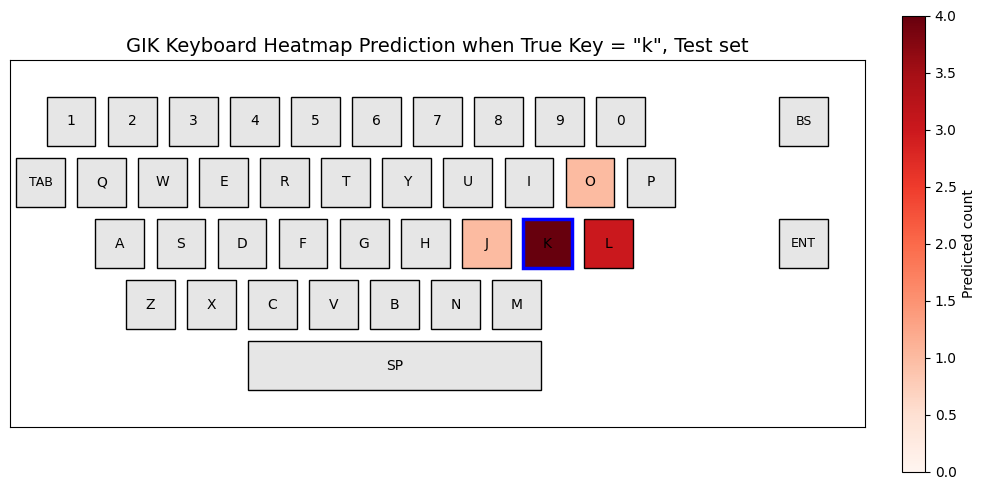

In [123]:
cm_orig = compute_confusion_matrix_40x40(trainer.test_dataset, model, DEVICE)

#plot_confusion_matrix_40x40(cm_orig, 'Test')

plot_virtual_keyboard_heatmap(cm_orig, 'k', 'Test')

# neighbours_a, cm_a = plot_anchor_with_closest_neighbours(cm_orig, 'i', 'Test', k_neighbours=5)

# neighbours_g, cm_g = plot_anchor_with_closest_neighbours(cm_orig, 'l', 'Test', k_neighbours=5)

# neighbours_l, cm_l = plot_anchor_with_closest_neighbours(cm_orig, 'l', 'Test', k_neighbours=13)

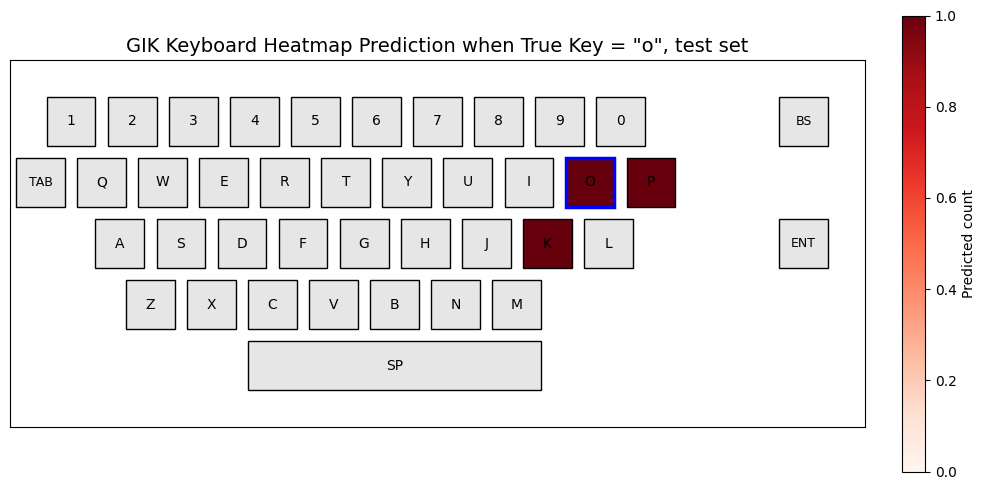

In [124]:
cm_orig_val = compute_confusion_matrix_40x40(trainer.val_dataset, model, DEVICE)

#plot_confusion_matrix_40x40(cm_orig, 'Test')

plot_virtual_keyboard_heatmap(cm_orig_val, 'o', 'test')

# neighbours_a_val, cm_a_val = plot_anchor_with_closest_neighbours(cm_orig_val, 'd', 'Validation', k_neighbours=12)

# neighbours_g_val, cm_g_val = plot_anchor_with_closest_neighbours(cm_orig_val, 'g', 'Validation', k_neighbours=20)

# neighbours_l_val, cm_l_val = plot_anchor_with_closest_neighbours(cm_orig_val, 'l', 'Validation', k_neighbours=13)

## Save Model

In [ ]:
# MODEL_PATH = os.path.join(DATA_DIR, "gik_model.pt")
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'config': CONFIG,
#     'input_dim': dataset.input_dim,
#     'metadata': metadata
# }, MODEL_PATH)
# print(f"Model saved to {MODEL_PATH}")